# Assignment 2/A
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!** 

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 


### Description
In this assignment you have to build a Mask R-CNN based instance segmentation model using [Detectron2](https://github.com/facebookresearch/detectron2). Detectron2 was written in PyTorch and contains many state-of-the-art obejct detection models with pretrained weights. (*Don't worry, you don't have to use any PyTorch specific function, just the methods provided by the Detectron2 package.*) 

First, you have to convert the Simpsons Main Characters dataset to COCO format. After that, finetune a pretrained instance segmentation model (which was trained on COCO dataset) to segment Simpson characters. Finally, to see the results, run it on some videos.

**You can use this notebook for guidance: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5**

*__Optional:__ You can get better a better grade on one of your assignments, if you temporally extend this method. By matching the bounding boxes using Hungarian algorithm, you can create a simple tracking method without modifying the network. Here you can find a good explanation of how it works: https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85 (It's enough to only implement the Hungarian matching part without using Kalman filter.)*  

### Use GPU
Runtime -> Change runtime type

At Hardware accelerator select  GPU then save it.  

### Useful shortcuts
* Run selected cell: *Ctrl + Enter*
* Insert cell below: *Ctrl + M B*
* Insert cell above: *Ctrl + M A*
* Convert to text: *Ctrl + M M*
* Split at cursor: *Ctrl + M -*
* Autocomplete: *Ctrl + Space* or *Tab*
* Move selected cells up: *Ctrl + M J*
* Move selected cells down: *Ctrl + M K*
* Delete selected cells: *Ctrl + M D*


### Tips
* **You may need to restart the notebook if the following cell returns some errors (red texts).**
* To prevent Google colab from disconnecting: https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0 


In [1]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=e46bfd51d6128454934926c36fdec596f07deab77066560d0bcaf7ef88d23755
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 1.7MB/s 
     |████████████████████████████████| 2.2MB 2.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-an

In [1]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Prepare dataset

* Download the Simpsons Main Characters dataset.Here you can find more information about the dataset: https://www.kaggle.com/mlwhiz/simpsons-main-characters 
* Preprocess the data.
  * In the `file_name`, replace the '\\' characters with '/'.
* Split the dataset into train-test sets. The test set should contain 8 images of each character.
* Convert the datasets to Detectron2's COCO format. Here you can find the format: https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts 
  * You only need to use these fields: `file_name, height, width, image_id, annotations`.
  * Each `annotation` field should contain a list that contains dictionaries with the following keys: `bbox, bbox_mode, category_id, iscrowd, segmentation` (*Note: `category_id` indexing should start from 0 (you can use the original `category_id-1`), and the value of `iscrowd` should be 0.*)
* Finally, register the datasets and visualize some (e.g. 3) samples (randomly), to check that everything works fine.
  * You have to set the `MetadataCatalog` as well, see: https://detectron2.readthedocs.io/tutorials/datasets.html#metadata-for-datasets

In [2]:
import os,json,sys,shutil
from detectron2.structures import BoxMode

In [3]:
# Download from Drive
!if ! [ -f simpsons_main_characters.zip ]; then curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1b-P1odn9flB1dj8rFJFN85nEaiVzbDbS" > /dev/null; curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1b-P1odn9flB1dj8rFJFN85nEaiVzbDbS" -o simpsons_main_characters.zip; fi

# Check if the file size is correct (~153MB)
!if (( $(stat -c%s simpsons_main_characters.zip) < 160652076 )); then rm -rfd simpsons_main_characters.zip; fi

# If not, download it from NIPG12
!wget -nc -O simpsons_main_characters.zip http://nipg1.inf.elte.hu:8000/simpsons_main_characters.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1736      0 --:--:-- --:--:-- --:--:--  1736
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M    0  153M    0     0  19.6M      0 --:--:--  0:00:07 --:--:-- 33.9M
File ‘simpsons_main_characters.zip’ already there; not retrieving.


In [11]:
!unzip simpsons_main_characters.zip

Streaming output truncated to the last 5000 lines.
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1038.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1039.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1040.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1041.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1042.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1043.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1044.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1045.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1046.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_1047.jpg  
  inflating: SimpsonsInstanceSegmentation-coco/test_images/bart_simpson/pic_104

In [ ]:
# # !rm -r "/content/train5"
# # !rm -r "/content/test5"
# # !rm -r "/content/train4"
# # !rm -r "/content/test4"
# # !rm -r "/content/output"
# !rm -r "/content/SimpsonsInstanceSegmentation-coco/"
!rm -r "/content/simpson/train"


In [4]:
os.mkdir("/content/simpson")

In [5]:
os.mkdir("/content/simpson/train")


In [6]:
os.mkdir("/content/simpson/test")

In [9]:
image_path="/content/SimpsonsInstanceSegmentation-coco/img"


In [12]:
l=[]
m=[]
c=0
c1=0
for i in os.listdir(image_path):
  # print (i)
 

  path=os.path.join(image_path + "/"+str(i))
  # print (path)
  for j in range(len(os.listdir(path))):
    # print (j)
    if j in [0,1,2,3,4,5,6,7]:
      # print (os.listdir(path)[j])
    
      path_2=os.path.join(path,os.listdir(path)[j])

      rename_path=path_2.split("/")[-2]+"_"+ os.listdir(path)[j]
      # print (rename_path)
      train_folder=os.path.join("/content/simpson/test",rename_path)   
      shutil.copyfile(path_2,train_folder)
      # print (train_folder)
      c=c+1
    else:
      path_2=os.path.join(path,os.listdir(path)[j])

      rename_path=path_2.split("/")[-2]+"_"+ os.listdir(path)[j]
      # print (rename_path)
      train_folder=os.path.join("/content/simpson/train",rename_path)   
      shutil.copyfile(path_2,train_folder)
      # print (train_folder)
      c1=c1+1

print (len(os.listdir("/content/simpson/train")))
print (len(os.listdir("/content/simpson/test")))

    
  


364
40


In [63]:
import sys
import pandas as pd

l=[]
m=[]
def get_dir (img_dir):
  with open("/content/SimpsonsInstanceSegmentation-coco/instances.json") as f:
    imgs_anns = json.load(f)
  dataset_dicts = []


  for j in imgs_anns["annotations"]:
    record = {}

    for i in imgs_anns["images"]:
      if j["image_id"]==i["id"]:
        a=i["file_name"].split("\\")
        a='_'.join(a)
        # print (a)
        dir=os.listdir(img_dir)
        if a in dir:          
          record["file_name"]=img_dir+ "/"+ i["file_name"].replace("\\","_")
          record["image_id"]=j["image_id"]
          record["height"]=i["height"]
          record["width"]=i["width"]
          
          objs = []
          seg=j["segmentation"][0]
          x=[]
          y=[]
          for m in range(0,len(seg),2):
            x.append(seg[m])
          for n in range(1,len(seg),2):
            y.append(seg[n])
          x_min=min(x)
          x_max=max(x)
          y_min=min(y)
          y_max=max(y)



          # if j["bbox"][0]>j["bbox"][2]:
          #   h=j["bbox"][0]
          #   j["bbox"][0]=j["bbox"][2]
          #   j["bbox"][2]=h
          # if j["bbox"][1]>j["bbox"][3]:
          #   h1=j["bbox"][1]
          #   j["bbox"][1]=j["bbox"][3]
          #   j["bbox"][3]=h1
                


          obj ={    "bbox":[x_min,y_min,x_max,y_max],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "iscrowd":0, 
                    "segmentation": j["segmentation"],                    
                    "category_id":int(j["category_id"])-1
                }
          objs.append(obj)
          record["annotations"] = objs
    if len(record)!=0:
      dataset_dicts.append(record)
  return dataset_dicts

print (len(get_dir("simpson/train")))
classes=["Homer","Marge","Maggie","Lisa","Bart"]



for d in ["train", "test"]:
    DatasetCatalog.register("simpson1_" + d, lambda d=d: get_dir("simpson/" + d))
    MetadataCatalog.get("simpson1_" + d).set(thing_classes=classes)





385


In [64]:
meta_data = MetadataCatalog.get("simpson1_train").set(thing_classes=classes)


{'bbox': [141.59554730983302, 144.6679035250464, 259.41372912801484, 405.9517625231911], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'segmentation': [[159.22820037105754, 150.27829313543603, 160.02968460111316, 184.74211502782933, 153.6178107606679, 202.37476808905384, 154.8200371057514, 212.7940630797774, 156.82374768089056, 230.02597402597405, 156.02226345083488, 248.05936920222643, 154.8200371057514, 259.6808905380334, 195.69573283859, 260.4823747680891, 203.30983302411875, 268.0964749536178, 201.70686456400745, 274.10760667903526, 187.28014842300558, 281.3209647495362, 184.8756957328386, 299.3543599257885, 186.0779220779221, 305.36549165120596, 181.66975881261595, 321.3951762523191, 179.66604823747684, 325.80333951762526, 166.0408163265306, 334.2189239332097, 150.81261595547312, 352.252319109462, 152.81632653061223, 365.0760667903525, 151.61410018552874, 377.4990723562152, 142.7977736549165, 393.12801484230056, 141.59554730983302, 399.139146567718, 146.8051948051948, 403.9480

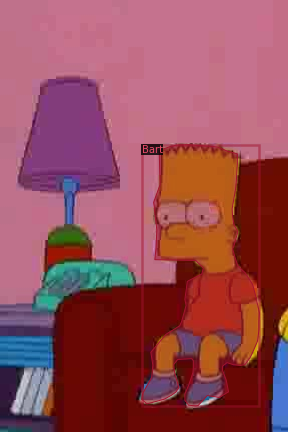

{'bbox': [0, 0, 210.62542264144395, 464], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'segmentation': [[210.62542264144395, 0, 138.33518862090287, 1.1102230246251565e-16, 101.89239332096469, 0.8608534322820045, 73.4842300556586, 66.7161410018553, 52.823747680890506, 129.98886827458256, 51.53246753246748, 144.19294990723563, 51.10204081632651, 168.29684601113175, 50.24118738404451, 172.60111317254177, 41.20222634508343, 190.67903525046384, 51.96289424860851, 203.59183673469389, 81.66233766233762, 206.1743970315399, 77.7884972170686, 219.08719851576996, 79.94063079777362, 220.37847866419298, 84.24489795918362, 232.86085343228203, 83.38404452690162, 237.59554730983305, 80.3710575139146, 252.6604823747681, 78.21892393320962, 261.69944341372917, 73.4842300556586, 269.8775510204082, 67.88868274582558, 277.1948051948052, 66.16697588126158, 294.4118738404453, 70.90166975881255, 306.8942486085344, 57.55844155844153, 323.68089053803345, 35.17625231910944, 343.0500927643785, 20.972170686456

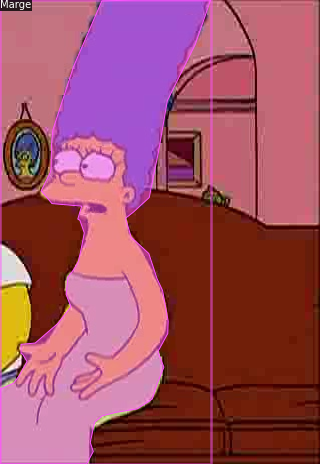

{'bbox': [31.762523191094658, 162.96846011131723, 263.3024118738404, 480], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'segmentation': [[263.3024118738404, 239.55473098330236, 225.45454545454544, 215.064935064935, 216.10389610389615, 183.0055658627087, 184.0445269016697, 188.34879406307974, 149.7588126159555, 162.96846011131723, 133.2838589981447, 188.34879406307974, 83.85899814471242, 185.6771799628942, 84.74953617810763, 219.5176252319109, 54.47124304267163, 238.6641929499072, 79.85157699443414, 264.4897959183673, 77.1799628942486, 272.5046382189239, 80.29684601113172, 280.0742115027829, 92.76437847866418, 287.19851576994427, 94.99072356215214, 291.6512059369202, 99.443413729128, 297.8849721706864, 100.33395176252321, 298.77551020408157, 109.23933209647498, 305.89981447124296, 110.12987012987014, 317.47680890538027, 106.12244897959187, 327.2727272727272, 103.89610389610391, 330.3896103896103, 97.2170686456401, 337.95918367346934, 97.2170686456401, 345.08348794063073, 100.779220

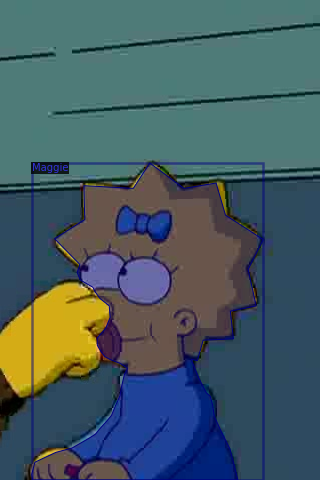

In [65]:
dataset_dicts = get_dir("simpson/train")
# print ((dataset_dicts))
for d in random.sample(dataset_dicts, 3):
# for d in dataset_dicts:
  path_=d["file_name"]
  # print (d["image_id"])
  print (d["annotations"][0])
  print (d["height"],d["width"])

  print ((path_))
  img = cv2.imread(path_)
  visualizer = Visualizer(img[:, :, ::-1], metadata=meta_data)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

    #  cv2_imshow(img)

## Try out the model
To test the model download the following image. Load the [pretrained R50-FPN 3x instance segmentation model](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-instance-segmentation-baselines-with-mask-r-cnn), evaluate it on the image, then visualize (plot) the result. 


In [16]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

In [17]:
img=cv2.imread("input.jpg")

In [18]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

model_final_f10217.pkl: 178MB [00:11, 14.9MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


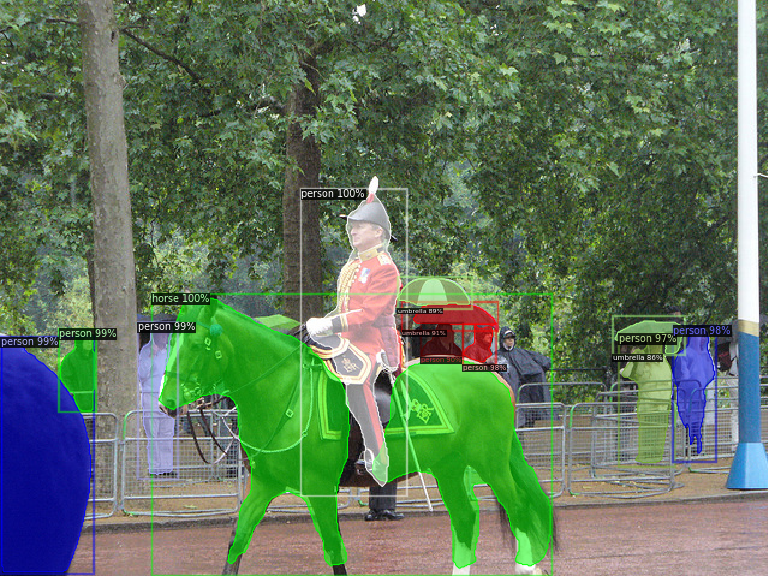

In [20]:
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Training
* Initialize the model with pretrained weights: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-instance-segmentation-baselines-with-mask-r-cnn
* Set the training parameters:
```
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
```
* Train the model. (*Note: To debug your code, you can reduce the MAX_ITER to 300 or 1000.*)  


In [66]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("simpson1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 300   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/10 15:39:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Evaluation
* Evalute the model on the test set.
* Visualize some (e.g. 5) results.
* Run the model on the following and an additional (arbitrary) videos:
  * https://www.youtube.com/watch?v=-doMNIdooe8&ab_channel=Nerdstalgic


In [67]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
print (cfg.MODEL.WEIGHTS)
predictor = DefaultPredictor(cfg)

./output/model_final.pth


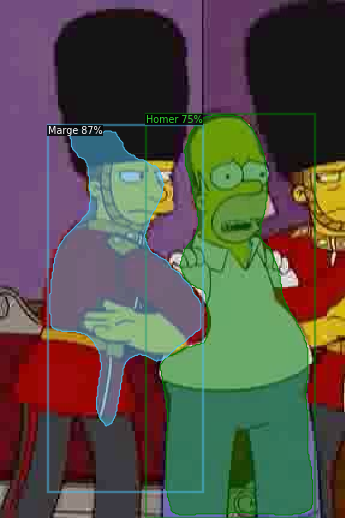

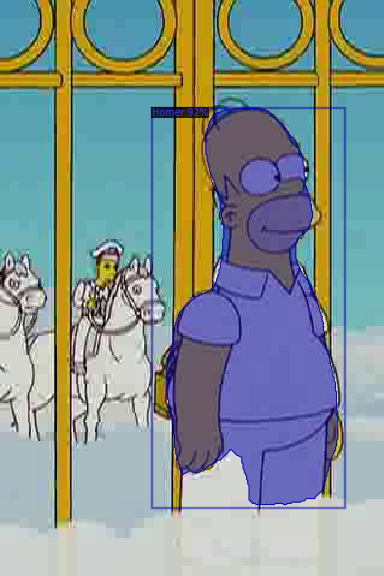

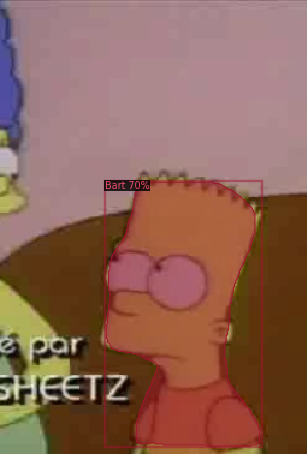

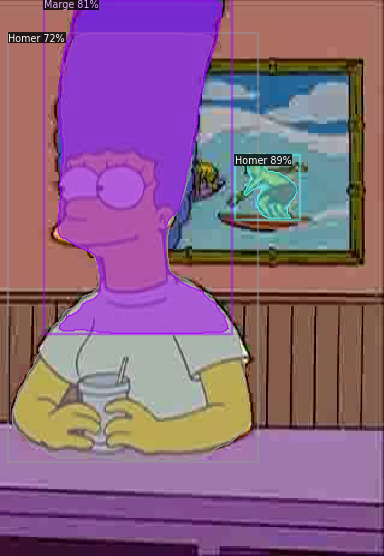

In [74]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dir("simpson/test")
for d in random.sample(dataset_dicts,4):    
    im = cv2.imread(d["file_name"])
    # print (d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("simpson_train"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

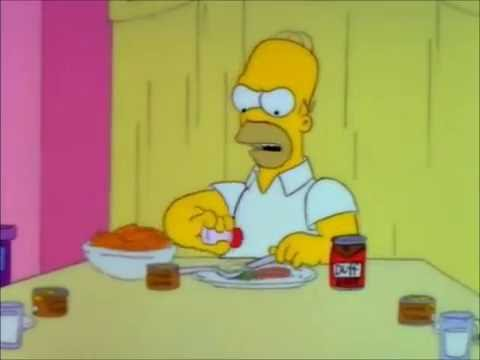

In [75]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("-doMNIdooe8", width=500)
display(video)

Download the videos:

In [77]:
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues

!youtube-dl https://www.youtube.com/watch?v=-doMNIdooe8&ab_channel=Nerdstalgic
!mv 'The Simpsons Funniest Scene--doMNIdooe8.mp4' video.mp4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
[youtube] -doMNIdooe8: Downloading webpage
[download] Destination: The Simpsons Funniest Scene--doMNIdooe8.f135.mp4
[download] 100% of 3.06MiB in 00:00
[download] Destination: The Simpsons Funniest Scene--doMNIdooe8.f140.m4a
[download] 100% of 850.25KiB in 00:00
[ffmpeg] Merging formats into "The Simpsons Funniest Scene--doMNIdooe8.mp4"
Deleting original file The Simpsons Funniest Scene--doMNIdooe8.f135.mp4 (pass -k to keep)
Deleting original file The Simpsons Funniest Scene--doMNIdooe8.f140.m4a (pass -k to keep)


In [ ]:
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl


Cloning into 'detectron2'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 8588 (delta 42), reused 54 (delta 33), pack-reused 8486
Receiving objects: 100% (8588/8588), 3.63 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (6184/6184), done.
Failed to load OpenCL runtime
[11/08 18:41:24 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='video-output.mkv', video_input='video.mp4', webcam=False)
[11/08 18:41:29 fvcore.common.checkpoint]: Loading checkpoint from detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
[11/08 18:41:29 fvcore.common.download]: Downloading from https://dl.fbaipublicfiles.com/detectron2/CO

In [ ]:
f = open('/content/output/config.yml', 'w')
f.write(cfg.dump())
f.close()

In [ ]:
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file /content/output/config.yml --video-input video.mp4 --confidence-threshold 0.8 --output video-output2.mkv \
  --opts MODEL.WEIGHTS /content/output/model_final.pth

fatal: destination path 'detectron2' already exists and is not an empty directory.
Failed to load OpenCL runtime
[11/08 19:17:13 detectron2]: Arguments: Namespace(confidence_threshold=0.2, config_file='/content/output/config.yml', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video-output2.mkv', video_input='video.mp4', webcam=False)
[11/08 19:17:18 fvcore.common.checkpoint]: Loading checkpoint from /content/output/model_final.pth
  0% 0/1640 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()
100% 1640/1640 [05:41<00:00,  4.80it/s]


In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Temporal extension (optional)
For more info see the description.
